# Gradient Estimation in 1-Step Navigation MDP

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import os
import time

import utils

%matplotlib inline

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Modeling 1-step transition and reward

<img src="files/img/1-step-Navigation.png">

### Deterministic parameterized policy
$$
\begin{equation}
a_{t+1} = \pi_{\theta}(s_t)
\end{equation}
$$

### Stochastic transition

$$
\begin{equation}
\sigma = \min \left \{ \sigma_{\text{min}}, \frac{\sigma_{\text{max}}}{\sqrt{2}} \Vert a_{t+1} \Vert \right \}, ~~ \sigma_{\text{min}} = \frac{2\pi}{360^o}\alpha_{\text{min}},~~\sigma_{\text{max}} = \frac{2\pi}{360^o}\alpha_{\text{max}}
\end{equation}
$$

$$
\begin{equation}
\alpha \sim \mathcal{N}(0, \sigma(\Vert a_{t+1} \Vert))
\end{equation}
$$

$$
\begin{equation}
\tilde{a}_{t+1} = R(\alpha) \cdot a_{t+1} = R(\alpha) = \begin{bmatrix}
\cos{\alpha} & -\sin{\alpha} \\
\sin{\alpha} & \cos{\alpha}
\end{bmatrix} \cdot a_{t+1}
\end{equation}
$$

$$
\begin{equation}
s_{t+1} = s_t + \tilde{a}_{t+1}
\end{equation}
$$

### Rewards
$$
\begin{equation}
r_{t+1} = -\Vert g - s_{t+1} \Vert
\end{equation}
$$

In [2]:
# domain parameters
grid = {
    'ndim': 2,
    'size': (10.0, 10.0),
    'start': (2.0, 2.0),
    'goal':  (8.0, 8.0)
}

In [3]:
# model

def sigma(velocity, alpha_min=0.0, alpha_max=10.0):
    sigma_min = 2 * np.pi / 360 * alpha_min
    sigma_max = 2 * np.pi / 360 * alpha_max
    return np.min([sigma_min, sigma_max / np.sqrt(2) * velocity])

def alpha(action):
    norm = np.linalg.norm(action)
    return np.random.normal(loc=0.0, scale=sigma(norm))

def R(alpha):
    cos, sin = np.cos(alpha), np.sin(alpha)
    return np.reshape([cos, -sin, sin, cos], (2, 2))

def transition(state, action):
    noisy_action = np.matmul(R(alpha(action)), action)
    return state + noisy_action

def reward(state):
    goal = np.reshape(grid['goal'], (2, 1))
    return -np.linalg.norm(state - goal)

def loss(directions, batch_size=100):
    start = np.reshape(grid['start'], (2, 1))
    losses = []
    for angle in directions:
        rad = 2 * np.pi / 360 * angle
        action = np.reshape([np.cos(rad), np.sin(rad)], (2, 1))
        rewards = []
        for _ in range(batch_size):
            next_state = transition(start, action)
            rewards.append(reward(next_state))
        losses.append(np.mean(rewards))
    return losses

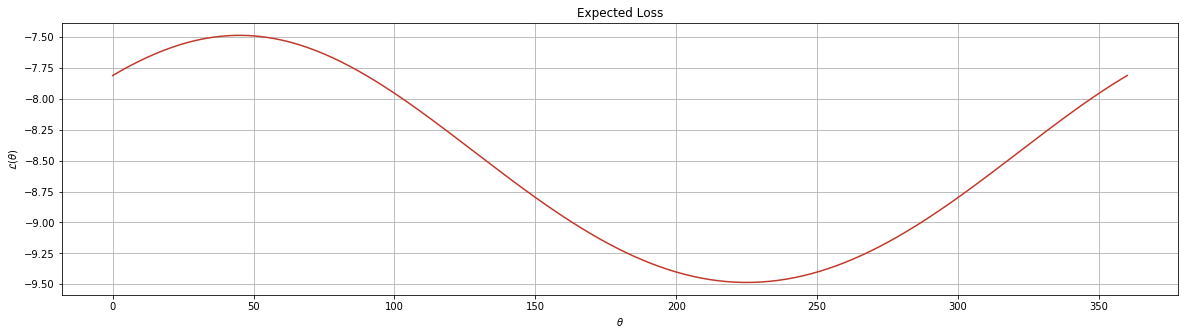

In [4]:
directions = np.arange(0, 361, dtype=np.float32)
losses = loss(directions)
utils.plot_expected_loss(directions, losses)

### Hyperparameters

In [5]:
# training hyperparameters
epoch = 200
learning_rate = 0.001
batch_size = 1000
max_time = 1

# TF-MDP with SGD

In [6]:
from tf_mdp.mdp.models.navigation import Navigation
from tf_mdp.mdp.rnn import MDP_RNN
from tf_mdp.mdp.loss import MSE_loss_function
from tf_mdp.policy.network import PolicyNetwork
from tf_mdp.policy.optimizer import SGDPolicyOptimizer
from tf_mdp.policy.simulate import PolicySimulator

In [7]:
graph = tf.Graph()

# MDP model
mdp = Navigation(graph, grid)

# define policy network
layers = [mdp.state_size + 1, 10, mdp.action_size]
policy = PolicyNetwork(graph, layers)

# RNN inputs
timesteps = utils.build_timesteps(batch_size, max_time)
initial_state = utils.build_initial_state(grid['start'][0], grid['start'][1], batch_size)

# unroll MDP model
rnn = MDP_RNN(mdp, policy)
rewards, states, actions, log_probs, final_state = rnn.unroll(initial_state, timesteps)

# loss function
total, loss = MSE_loss_function(graph, rewards)

# optimizer
optimizer = SGDPolicyOptimizer(graph, learning_rate, loss, total)

# let's train the model!
path = os.path.abspath('logs/navigation/1-step/train/model.ckpt')
losses, saver, uptime = optimizer.minimize(epoch, path)

Epoch   199: loss = 50.500766754150394
Done in 1.269962 sec.

Model saved in file: /Users/thiagopbueno/Projects/jupyter-notebooks/gradient-estimators/notebooks/logs/navigation/1-step/train/model.ckpt


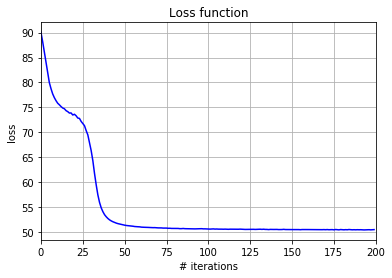

In [8]:
# visualize training
utils.plot_loss_function(losses, epoch)

INFO:tensorflow:Restoring parameters from /Users/thiagopbueno/Projects/jupyter-notebooks/gradient-estimators/notebooks/logs/navigation/1-step/train/model.ckpt
>> Action:

Mean:   [ 0.99543887  0.99348974]
Stddev: [  7.33137449e-06   1.57356262e-05]


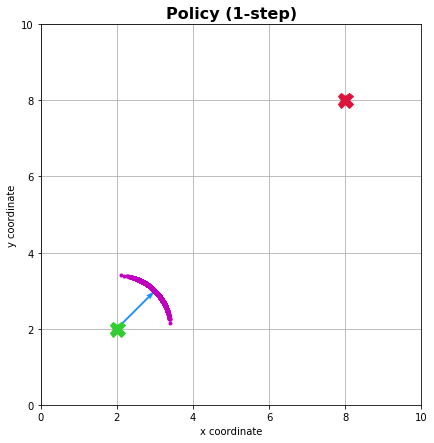

In [9]:
# simulations
simulation_batch_size = 10000
simulation_max_time = 1

s0 = utils.build_initial_state(grid['start'][0], grid['start'][1], simulation_batch_size)
timesteps = utils.build_timesteps(simulation_batch_size, simulation_max_time)

states_, actions_ = PolicySimulator(graph, path).run([states, actions], s0, timesteps)

states_ = np.reshape(states_,(simulation_batch_size, 2) )
actions_ = np.reshape(actions_,(simulation_batch_size, 2) )

print('>> Action:')
print('\nMean:  ', np.mean(actions_, axis=0))
print('Stddev:',   np.std(actions_, axis=0))

a = np.mean(actions_, axis=0)

fig = plt.figure(figsize=(7, 7))
utils.plot_policy(grid, a, states_)